## Introduction

In this notebook I demonstrate the main features of the BayesCART package and how to use it for sampling from the posterior distribution of Bayesian Classification and Regression Trees (CART). For this, we focus on solving the CGM98 example. The challenge lies in the multimodality of the posterior distribution, which renders traditional MCMC approaches useless in exploring all the modes. 

For such problems, a standard solution is to use parallel (geometric) tempering to improve the exploration at a higher computational cost. While usually effective, it has severe limitations for Bayesian CART models due to the structure of the posterior. Hence, we need to implement custom approaches that suitably adapt to the tree data structure. These are called geometric-likelihood tempering and pseudo-prior temepring in the code. Both approach are similar in spirit and perform similarly, with pseudo-prior being more generic, more theoretically sound, and generally preferred.

In [5]:
from joblib import Parallel, delayed
import numpy as np
from bayescart import BCARTClassic, NodeDataRegression, Tree, sim_cgm98, BCARTGeomLik, BCARTGeom, BCARTPseudoPrior
from bayescart.utils import plot_hists, plot_chain_comm, plot_swap_prob
from bayescart.eval import produce_tree_table
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## CGM98 original Approach

This is a simulated example for which we know what the ground truth is. After sampling data from the generating process, we construct the true tree to be able to ascertain when the sampler recovers it. While there can be variations due to noise in the data, in the limit the most likely tree should correspond with the true tree.

Generate data

In [6]:
seed = 34647
rng = np.random.default_rng(seed)
X, y = sim_cgm98(800, rng)

Building the true tree

In [7]:
root_node_data = NodeDataRegression(np.nan, np.nan, X, y, rng=rng, debug=True, node_min_size=1)

true_tree = Tree(root_node_data=root_node_data, rng=rng, debug=True, node_min_size=1)
root = true_tree.get_root()
root.update_split_info('v2', ['a','b'])
root.update_node_params((np.nan, np.nan))
node2 = true_tree.add_node(root_node_data.copy(), is_l=True, parent=root)
node2.update_split_info('v1', 5)
node2.update_node_params((np.nan, np.nan))
node3 = true_tree.add_node(root_node_data.copy(), is_l=False, parent=root)
node3.update_split_info('v1', 3)
node3.update_node_params((np.nan, np.nan))
node4 = true_tree.add_node(root_node_data.copy(), is_l=True, parent=node2)
node4.update_node_params((8, 2))
node4.reset_split_info()
node5 = true_tree.add_node(root_node_data.copy(), is_l=False, parent=node2)
node5.update_node_params((2, 2))
node5.reset_split_info()
node6 = true_tree.add_node(root_node_data.copy(), is_l=True, parent=node3)
node6.update_node_params((1, 2))
node6.reset_split_info()
node7 = true_tree.add_node(root_node_data.copy(), is_l=False, parent=node3)
node7.update_split_info('v1', 7)
node7.update_node_params((np.nan, np.nan))
node8 = true_tree.add_node(root_node_data.copy(), is_l=True, parent=node7)
node8.update_node_params((5, 2))
node8.reset_split_info()
node9 = true_tree.add_node(root_node_data.copy(), is_l=False, parent=node7)
node9.update_node_params((8, 2))
node9.reset_split_info()

true_tree.update_subtree_data(root)
true_tree.is_valid()

bcart_truth = BCARTClassic(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=1010, burnin=10, thinning=1, move_prob=[1,1,1,1], debug=True, light=False, seed=rng)
true_llik = bcart_truth.calc_llik(true_tree)
true_post = bcart_truth.get_log_posterior_prob(true_tree)

Run the MCMC sampler. Note that, as originally presented in the CGM98 paper, this approach focuses on running multiple short chains that quickly converge on a mode and get stuck. Once this happens, the sampler is restarted from another random part of the space. Repeating this process, the hope is to cover all the modes, and, out of chance, find at least once the tree(s) with highest posterior probability.

Issues:
- It is not possible to obtain a posterior sample (a collection of trees sampled from the posterior distribution)
- Identifying the best tree is tricky. The most frequently found has not inherent meaning in this case. In practice, trees are compared using the integrated likelihood. Using the posterior tree probability is discouraged, see the original paper.

Using the integrated log-likelihood is reasonable but it falls short of a full Bayesian approach. In fact, one could interpret this algorithm as a Bayesian-driven tree search, but tree evaluation is done using classical statistics (e.g. the likelihood).

Of course, the MCMC could _theoretically_ be run longer and, with sufficient thinning, recover a posterior sample. The issue is computational, not theoretical: in practice the algorithm has no way to escape locally optimal trees.

In [8]:
def run_classic_MCMC(X, y, seed):
    bcart = BCARTClassic(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=1010, burnin=10, thinning=4, move_prob=[1,1,1,1], light=False, seed=seed, verbose='')
    res = bcart.run()
    return res['posterior_store'], res['integr_llik_store'], res['tree_term_reg']

res = Parallel(-1)(delayed(lambda i: run_classic_MCMC(X, y, i))(seed+i) for i in range(10))
post, llik, term_reg = zip(*res)

Let's visualize the outcome. Below we aggregate each of the 10 independent runs in a single plot. The beginning of each run is clearly visible as when it resets, starting from a stump means that the metrics we use are usually pretty poor, until better trees are found by the sampler. 


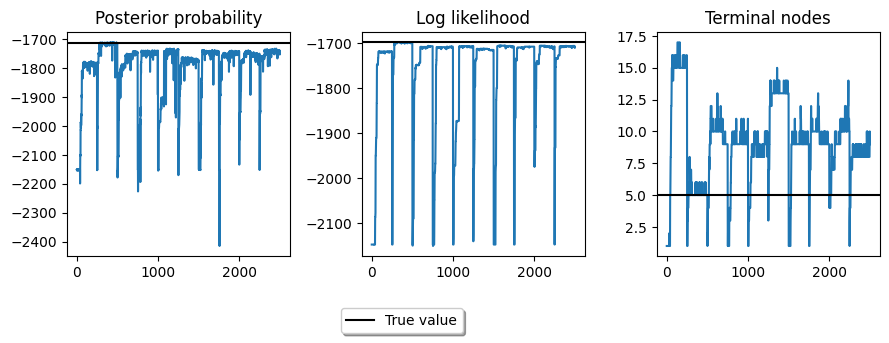

In [9]:
def unravel(l):
    out = []
    [out.extend(x) for x in l]
    return out

fig,ax = plt.subplots(1,3, figsize=(9,3)) # (8,3) is also good, maye better)
ax[0].plot(unravel(post))
ax[0].axhline(true_post, color='black')
ax[0].set_title('Posterior probability')

# fig,ax = plt.subplots()
ax[1].plot(unravel(llik))
ax[1].axhline(true_llik, color='black')
ax[1].set_title('Log likelihood')

# fig,ax = plt.subplots()
ax[2].plot(unravel(term_reg))
ax[2].axhline(5, color='black')
fig.tight_layout()
ax[2].set_title('Terminal nodes')

# I want to put an horizontal legend below all the three plots showing only the black line as entry
ax[0].legend([Line2D([0],[0],c='black')], ['True value'], loc='upper center', bbox_to_anchor=(1.5, -0.2), ncol=1, fancybox=True, shadow=True)

## Parallel Tempering

Parallel tempering is a general technique that explores multiple flattened versions of the posterior landscape simultaneously. For each flattened posterior, an MCMC chain is run, with occasional probability-based swaps across chains. This allows some chains to explore a space where they can freely move across modes because the landscape is flat. The increased mobility is traded for a much smaller posterior signal: it's hard in this landscape to understand which trees are better than others because they all tend to have very similar posterior probability (hence why it's flat). However, by swapping the states and propagating through other chains with a more pronounced landscape, they can help other chains to "jump" from mode to mode. This works well when the chains are not too far from each other and swapping is accepted fairly frequently.

Here we look at three types of parallel tempering:
- **Geometric**: the posterior is flattened in a geometric progression, according to a temperature parameter (same intuition as annealing). This is the standard approach.
- **Geometric-likelihood**: only the likelihood is flattened. The tree prior is used to bias the exploration towards smaller trees. This works very well, but prevents encoding prior information, as it is used as a computational device for speeding up the algorithm convergence.
- **Pseudo-prior**: a pseudo-prior is introduced to encourage certain tree sizes during exploration, leaving the original prior unchanged and free to encode prior knowledge.

For each algorithm, we run 8 independent simulation ("runs") from a different random initialization, to inspect whether the chain is moving effectively over the space. For each run, one (classic) or multiple (tempering) chains are propagated in parallel. All algorithm run with the same number of total MCMC steps (across chains), yielding comparable results. In the standard MCMC, each iteration is one MCMC step. However, for tempering, MCMC steps are distributed over the chains, leading to a smaller number of total iterations (in the target chain). 

For this simulations, geometric tempering uses 8 chains, while the others rely on 4 each. The number of chains is chosen to have reasonable overlap and acceptance probability between them, otherwise the algorithm is unable to move properly across the space. This depends on the temperature setting for each chain (flattening effect). We will explore this next.


Note: the simulations below can take between 20 mins to a few hours depending on your hardware.

In [10]:

base_iter = 50000
base_burnin = 1000
thinning_base = 20
tree_spacing_base = 20

# If the chains mix slowly, then you'll want the spacing to be big enough. 20 is a reasonable guess for this model. Otherwise, the better approach is to dedicate as much compute time as possible. You can always chop the results and/or run again for less.

def run_classic_MCMC(X, y, seed):
    mult = 8
    bcart = BCARTClassic(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=mult*base_iter, burnin=mult*base_burnin, thinning=mult*thinning_base, move_prob=[1,1,1,1], light=False, seed=seed, verbose='', store_tree_spacing=mult*tree_spacing_base)
    return bcart.run()

def run_geom_tempering(X, y, seed):
    mult = 1
    bcart = BCARTGeom(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=mult*base_iter, burnin=mult*base_burnin, thinning=mult*thinning_base, move_prob=[1,1,1,1], light=False, seed=seed, temps = (1,0.85, 0.7,0.48,0.31,0.2,0.08,1e-7), verbose='', store_tree_spacing=mult*tree_spacing_base)
    return bcart.run()

def run_geom_lik_tempering(X, y, seed):
    mult =  2
    bcart = BCARTGeomLik(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=mult*base_iter, burnin=mult*base_burnin, thinning=mult*thinning_base, move_prob=[1,1,1,1], light=False, seed=seed, temps = (1, 0.04, 0.011, 0.005), verbose='', store_tree_spacing=mult*tree_spacing_base)
    return bcart.run()

def run_pseudo_prior_tempering(X, y, seed):
    mult= 2 
    bcart = BCARTPseudoPrior(X, y, alpha=0.95, beta=1, a=1/3, mu_bar=4.85, nu=10, lambd=4, iters=mult*base_iter, burnin=mult*base_burnin, thinning=mult*thinning_base, move_prob=[1,1,1,1], light=False, seed=seed, temps = (1, 0.065, 0.028, 0.015), verbose='', store_tree_spacing=mult*tree_spacing_base, pprior_alpha=0.95, pprior_beta=1.6)
    return bcart.run()

seed = 34647
rng = np.random.default_rng(seed)
X, y = sim_cgm98(800, rng)

# Runtime is about 20mins for each, except Geom whic his 30 min.

res_classic = list(Parallel(-1)(delayed(lambda i: run_classic_MCMC(X, y, i))(seed+i) for i in range(8)))
res_geom = list(Parallel(-1)(delayed(lambda i: run_geom_tempering(X, y, i))(seed+i) for i in range(8)))
res_geom_lik = list(Parallel(-1)(delayed(lambda i: run_geom_lik_tempering(X, y, i))(seed+i) for i in range(8)))
res_pp = list(Parallel(-1)(delayed(lambda i: run_pseudo_prior_tempering(X, y, i))(seed+i) for i in range(8)))

mdls = [res_classic, res_geom, res_geom_lik, res_pp]

# relatively expensive to run, the implementation is not parallelized
summary_tbls = [produce_tree_table(res) for res in mdls]

Notice the sensible gains in runtime for geometric-likelihood and pseudo-prior approaches. That is due to the exploration of smaller trees, that are computationally cheaper. This is more pronounced the bigger the dataset.

In [11]:
names = ['Classic MCMC', 'Geometric Tempering', 'Geometric Likelihood Tempering', 'Pseudo Prior Tempering']
for res, name in zip(mdls, names):
    timings = res[0]['timings']
    print(f'{name}. \nElapsed time: {timings["elap_time_human"]}, Tot iters: {timings["tot_mh_steps"]}, Iters/min: {timings["iters/min"]}/min')

Classic MCMC. 
Elapsed time: 6 minutes and 49 seconds, Tot iters: 400000, Iters/min: 58613/min
Geometric Tempering. 
Elapsed time: 8 minutes and 21 seconds, Tot iters: 50000, Iters/min: 5984/min
Geometric Likelihood Tempering. 
Elapsed time: 5 minutes and 16 seconds, Tot iters: 100000, Iters/min: 18972/min
Pseudo Prior Tempering. 
Elapsed time: 5 minutes and 32 seconds, Tot iters: 100000, Iters/min: 18041/min


### Checking chain alignment

Let us assess the current temperature setup for tempering. Each histogram represents the distribution of terminal regions for a given chain. As remarked, we want chains to partially overlap to encourage more frequent swaps. For this analysis we will consider only one run of each algorithm.

[0.31 0.36 0.19 0.07 0.28 0.21 0.14 0.  ]


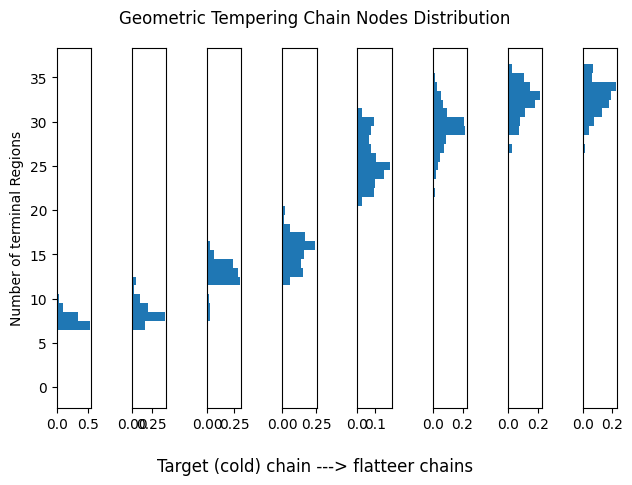

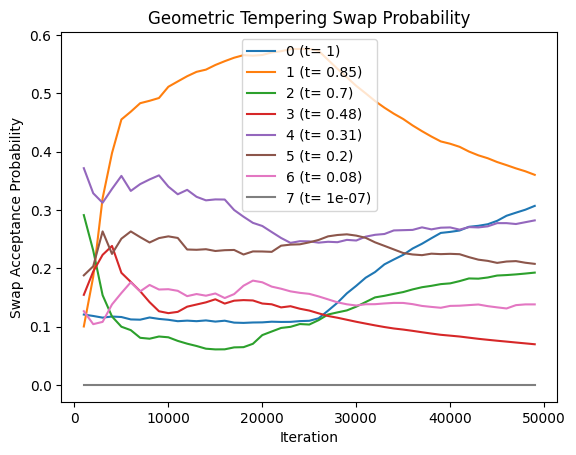

In [12]:
plot_chain_comm(res_geom[0], title='Geometric Tempering Chain Nodes Distribution') 
plot_swap_prob(res_geom[0], title='Geometric Tempering Swap Probability')

[0.03 0.03 0.78 0.  ]


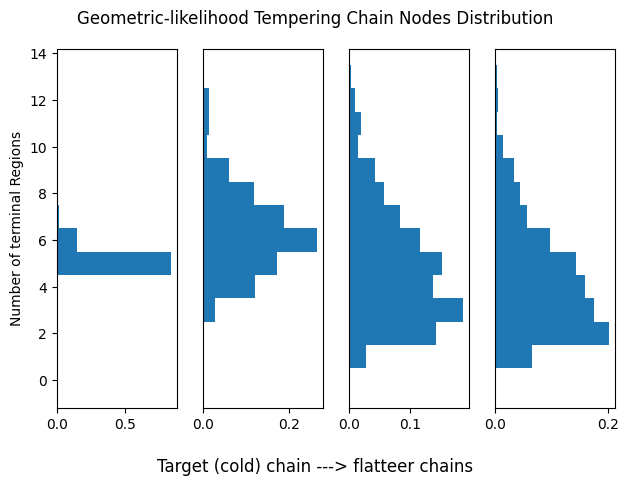

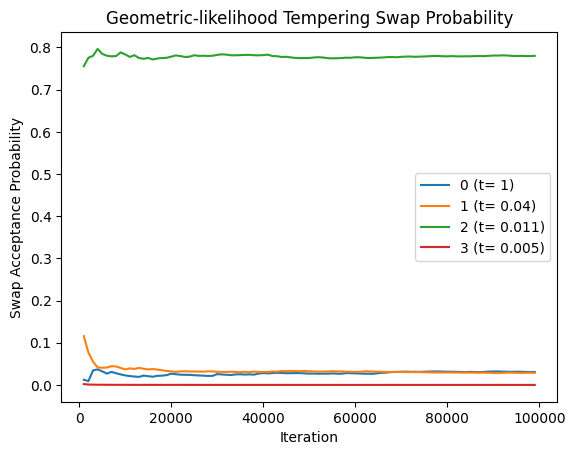

In [13]:
plot_chain_comm(res_geom_lik[0], title='Geometric-likelihood Tempering Chain Nodes Distribution') 
plot_swap_prob(res_geom_lik[0], title='Geometric-likelihood Tempering Swap Probability')

[0.24 0.15 0.25 0.  ]


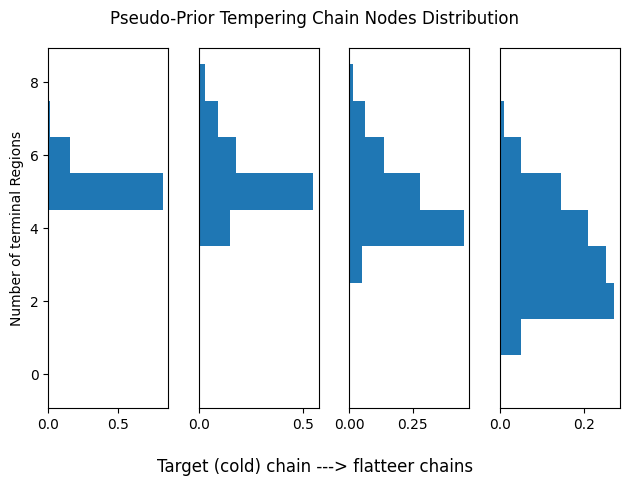

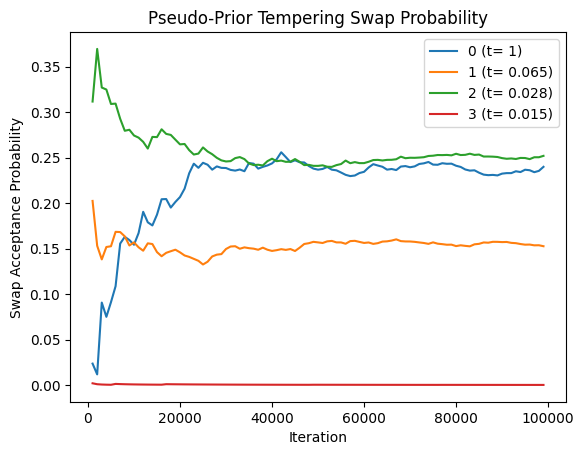

In [14]:
plot_chain_comm(res_pp[0], title='Pseudo-Prior Tempering Chain Nodes Distribution') 
plot_swap_prob(res_pp[0], title='Pseudo-Prior Tempering Swap Probability')

### Assessing tempering performance

We use two indicators of performance. First, we would want the marginal distribution of features of interest to be consistent across runs. For this, we consider the number of terminal regions. While this does not guarantee convergence, terminal regions are usually a good proxy of at least identifying good trees.

The rigorous (and far stricter) test is to compare the posterior probability of the same tree across runs. A sampler that mixes well will be able to identify the same high posterior trees in all runs. This is represented in the table. Note that a value of zero means the given tree was sampled $< 1\%$.

Using from step 0 to 2450 for plotting
    C0    C1   C2   C3    C4   C5    C6    C7    Mn   Std    b
0  0.0  0.85  0.0  0.0  0.00  0.0  0.87  0.00  0.22  0.37  5.0
1  0.0  0.00  0.0  0.8  0.00  0.0  0.00  0.06  0.11  0.26  6.0
2  0.0  0.00  0.0  0.0  0.00  0.0  0.00  0.42  0.05  0.14  7.0
3  0.0  0.00  0.0  0.0  0.39  0.0  0.00  0.00  0.05  0.13  8.0
4  0.0  0.00  0.0  0.0  0.34  0.0  0.00  0.00  0.04  0.11  8.0


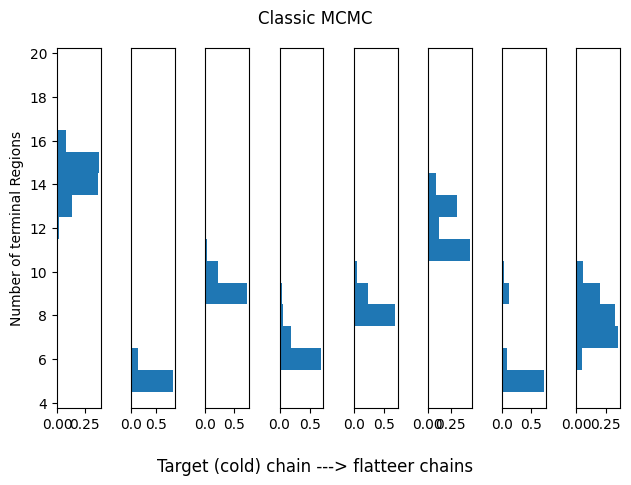

In [16]:
idx_range = (0,1)
plot_hists(res_classic, idx_range=idx_range, title='Classic MCMC')
print(summary_tbls[0][:5])

Using from step 0 to 2450 for plotting
     C0   C1    C2    C3   C4    C5    C6    C7    Mn   Std    b
0  0.00  0.0  0.55  0.00  0.7  0.28  0.00  0.00  0.19  0.27  6.0
1  0.32  0.0  0.00  0.00  0.0  0.00  0.00  0.38  0.09  0.15  7.0
2  0.00  0.0  0.00  0.00  0.0  0.00  0.00  0.36  0.04  0.12  9.0
3  0.00  0.0  0.00  0.26  0.0  0.00  0.00  0.00  0.03  0.09  7.0
4  0.00  0.0  0.00  0.00  0.0  0.00  0.22  0.00  0.03  0.07  7.0


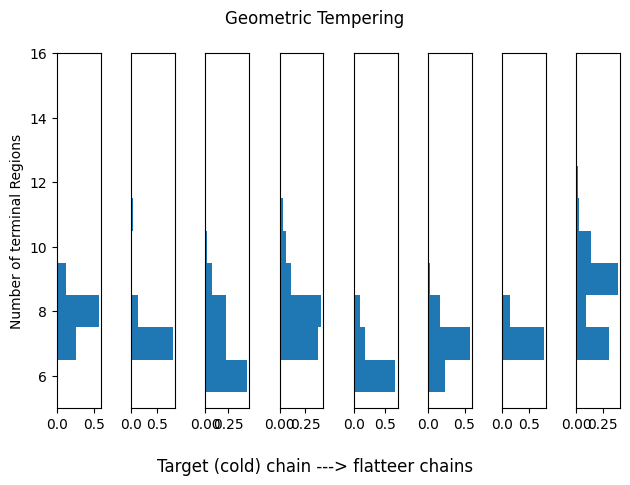

In [17]:
idx_range = (0,1)
plot_hists(res_geom, idx_range=idx_range, title='Geometric Tempering')
print(summary_tbls[1][:5])

Using from step 0 to 2450 for plotting
     C0    C1    C2    C3    C4    C5    C6    C7    Mn   Std    b
0  0.77  0.72  0.85  0.78  0.81  0.81  0.76  0.74  0.78  0.04  5.0
1  0.02  0.02  0.02  0.01  0.02  0.02  0.02  0.02  0.02  0.00  6.0
2  0.00  0.07  0.00  0.03  0.00  0.00  0.00  0.03  0.02  0.02  6.0
3  0.01  0.01  0.02  0.02  0.01  0.02  0.01  0.02  0.02  0.00  6.0
4  0.03  0.00  0.00  0.00  0.02  0.01  0.02  0.03  0.01  0.01  6.0


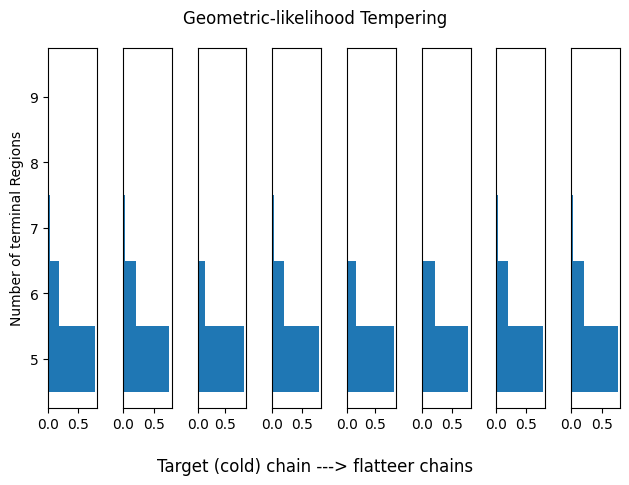

In [18]:
idx_range = (0,1)
plot_hists(res_geom_lik, idx_range=idx_range, title='Geometric-likelihood Tempering')
print(summary_tbls[2][:5])

Using from step 0 to 2450 for plotting
     C0    C1    C2    C3    C4    C5    C6    C7    Mn   Std    b
0  0.80  0.81  0.80  0.83  0.80  0.79  0.72  0.78  0.79  0.03  5.0
1  0.01  0.01  0.02  0.01  0.02  0.02  0.02  0.02  0.02  0.00  6.0
2  0.02  0.02  0.02  0.01  0.02  0.01  0.01  0.01  0.02  0.00  6.0
3  0.01  0.01  0.01  0.01  0.02  0.01  0.01  0.01  0.01  0.00  6.0
4  0.01  0.01  0.01  0.01  0.01  0.01  0.02  0.01  0.01  0.00  6.0


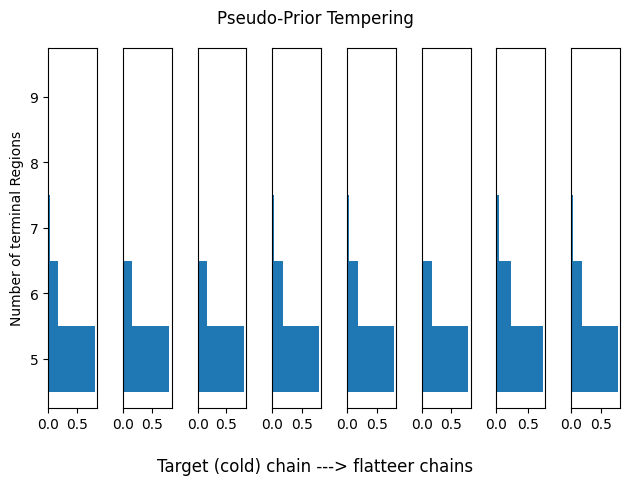

In [19]:
idx_range = (0,1)
plot_hists(res_pp, idx_range=idx_range, title='Pseudo-Prior Tempering')
print(summary_tbls[3][:5])